The goal of this notebook is to do exploratory analysis on whether different chord progressions appear at different rates in different genres.

In [2]:
# importing basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import copy
from collections import Counter, deque

# read in the data set
df = pd.read_csv('../data/chordonomicon.csv', low_memory=False)

In [3]:
# Read the mapping CSV file
chord_relations = pd.read_csv('../data/chords_mapping.csv')

# Create a dictionary with keys the "chords" and values the "degrees"
chord_degrees = dict(zip(chord_relations['Chords'], chord_relations['Degrees']))
for key, value in chord_degrees.items():
    chord_degrees[key] = ast.literal_eval(value)
    
# full list of chords from the chords_mapping csv
known_chords = list(chord_degrees.keys())

In [4]:
# drop all columns except for chords and genres
chord_data = df[['chords','genres']]

# drop anything that lacks chord or genre data
chord_data = chord_data.dropna()

The next few blocks clean up the data: replacing spaces with commas in the chords, removing section markers from chord strings, removing inversions from chord strings, and simplifying the genres.

In [6]:
# replacing spaces with commas
def replace_space_with_comma(my_string):
    return my_string.replace(" ",",")

# Remove section markers
def remove_section_markers(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '<':
            # Skip until after the following ", "
            j = my_string.find('>', i)
            if j == -1:
                break  # no closing '>', stop
            i = j + 2  # skip '>,' and the space
        else:
            result.append(my_string[i])
            i += 1
    assert('<' not in result)
    assert('>' not in result)
    return ''.join(result)

# Remove inversions
def remove_inversions(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '/':
            # Skip until after the following ", "
            j = my_string.find(',', i)
            if j == -1:
                break  # no closing comma, stop
            i = j  # skip comma
        else:
            result.append(my_string[i])
            i += 1
    return ''.join(result)

def clean_up_chord_string(my_string):
    return remove_inversions(
        remove_section_markers(
            replace_space_with_comma(my_string)))

# replacing spaces with commons in all chords in all rows of the data
chord_data.loc[:,'chords'] = chord_data['chords'].apply(clean_up_chord_string)

In [7]:
# simplify genre data
major_genres = ['pop','rock','country','alternative','punk','metal','rap','soul','jazz','reggae','electronic']
def simplify_genre(genre_string):
    for g in major_genres:
        if g in genre_string:
            return g
    return 'other'

chord_data.loc[:,'genres'] = chord_data['genres'].apply(simplify_genre)
major_genres.append('other')

In [8]:
genre_counter = Counter(chord_data.genres)
genre_counter

Counter({'pop': 131247,
         'other': 106961,
         'rock': 81276,
         'country': 15884,
         'punk': 10060,
         'alternative': 4358,
         'rap': 4013,
         'metal': 3007,
         'soul': 2909,
         'reggae': 2156,
         'jazz': 1857,
         'electronic': 545})

In [9]:
# sort genres by frequency in the total database
major_genres = [t[0] for t in genre_counter.most_common()]
major_genres

['pop',
 'other',
 'rock',
 'country',
 'punk',
 'alternative',
 'rap',
 'metal',
 'soul',
 'reggae',
 'jazz',
 'electronic']

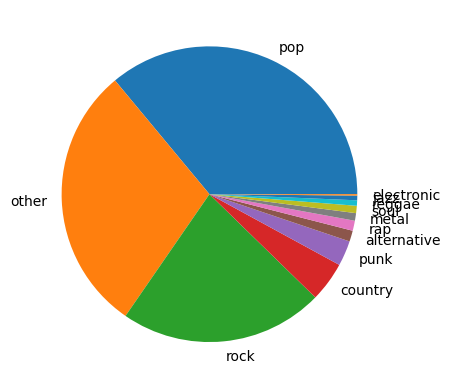

In [10]:
# Pie chart of genres in the whole data set
plt.pie(x = [t[1] for t in genre_counter.most_common()], 
        labels = [t[0] for t in genre_counter.most_common()])
plt.show()

In [11]:
# method to transpose a chord in vector format
def transpose_chord_up(chord_vector, num_semitones):
    d = deque(chord_vector)
    d.rotate(num_semitones)
    return(list(d))
    
# method to return true if chord_1 and chord_2 are just tranposed versions of each other
def is_harmonic_equivalent(chord_1, chord_2):
    # if they have different numbers of notes, then we don't have to check if 
    # any of the transpositions are equal
    if sum(chord_1) != sum(chord_2):
        return False

    # if they have the same number of notes, just rotate through the 12 possible transpositions to check
    for i in range(12):
        if np.array_equal(chord_1, transpose_chord_up(chord_2, i)):
            return True

    return False

C = chord_degrees['C']
D = chord_degrees['D']
E = chord_degrees['E']
G = chord_degrees['G']
assert(is_harmonic_equivalent(C,D))
assert(is_harmonic_equivalent(C,E))
assert(is_harmonic_equivalent(D,E))
assert(is_harmonic_equivalent(C,G))

Cmaj7 = chord_degrees['Cmaj7']
Dmaj7 = chord_degrees['Dmaj7']
assert(is_harmonic_equivalent(Cmaj7,Dmaj7))

In [12]:
# function to convert a string of comma-separated chords into a matrix, where each row denotes a chord
def string_to_chord_matrix(chord_sequence):
    # split sequence over commas, ignoring any "empty string" chords
    chord_list = [c for c in chord_sequence.split(',') if c != '']
    
    # then look up each chord in chord_degrees dictionary by the key value
    return np.array([chord_degrees[c] for c in chord_list])

def transpose_matrix_up(chord_matrix, num_semitones):
    # transpose the entire matrix up by a number of semitones
    # this just means applying transpose_chord_up to each row
    return np.array([transpose_chord_up(row,num_semitones) for row in chord_matrix])

def is_harmonic_equivalent_matrix(chord_matrix_1, chord_matrix_2):
    # return true if chord_matrix_1 and chord_matrix_2 are just tranposed versions of each other

    # some basic checks to skip some looping when we can rule that out already
    if chord_matrix_1.shape != chord_matrix_2.shape:
        return False
    
    for i in range(len(chord_matrix_1)):
        if chord_matrix_1[i].sum() != chord_matrix_2[i].sum():
            return False

    # loop to check if they're the same
    for i in range(12):
        if np.array_equal(chord_matrix_1, transpose_matrix_up(chord_matrix_2, i)):
            return True

    return False

CD = string_to_chord_matrix('C,D')
DE = string_to_chord_matrix('D,E')
assert(is_harmonic_equivalent_matrix(CD,DE))

In [13]:
# return true/false depending on if a song contains a literal/raw equivalent n_gram to the input n_gram
def contains_raw_n_gram(song, n_gram):
    # assumption: input song is a comma-separated string of chord names
    # assumption: input n_gram is a comma-separated string of chord names
    return (n_gram in song)

assert(contains_raw_n_gram('A,B,C,D,Emin','B,C,D'))

# return true/false depending on if a song contains a harmonically equivalent n_gram to the input n_gram
def contains_n_gram(song, n_gram):
    # assumption: input song is a comma-separated string of chord names
    # assumption: input n_gram is a comma-separated string of chord names
    song_as_matrix = string_to_chord_matrix(song)
    n_gram_as_matrix = string_to_chord_matrix(n_gram)
    song_length = len(song_as_matrix)
    n = len(n_gram_as_matrix)
    for i in range(song_length - n):
        if is_harmonic_equivalent_matrix(n_gram_as_matrix, song_as_matrix[i:i+n]):
            return True
    return False

assert(contains_n_gram('A,B,C,D,Emin','B,C,D'))
assert(contains_n_gram('C,G,C,F,G','C,G,C'))
assert(contains_n_gram('C,G,C,F,G','D,A,D'))
assert(contains_n_gram('C,G,C,F,G','E,B,E'))

In [14]:
# example of how to add a one-hot encoding column for whether songs contain a given n-gram, up to harmonic equivalent
song_df = copy.deepcopy(chord_data.sample(10))
raw_chord = 'G,C' # representative concrete example of an n-gram
harmonic_function = '51' # new column title
song_df.insert(loc=len(song_df.columns),
               column = harmonic_function,
               value = song_df['chords'].apply(lambda song : int(contains_n_gram(song, raw_chord))))
song_df

,chords,genres,51
31808,"D,G,C,G,C,F,A,D,A,C,Emin,D,A,D,A,F,C,G,D,G,C,F...",pop,1
100765,"D,D,A,Bmin,A,D,D,A,Bmin,A,G,A,G,Bmin,Emin,Bmin...",other,1
339762,"Amin,C,G,Amin,C,G,Amin,C,G,Amin,F,Amin,G,Amin,...",other,1
163499,"B,G,Emin,B,G,A,B,G,Emin,E,B,G,Emin,B,G,A,B,G,E...",pop,0
391317,"E,B,Csmin,A,Gs,Gsmin,Csmin,A,E,Csmin,A,B,Csmin...",rock,0
108805,"Gsmin,Csmin,Asdim,Gsmin,Csmin,Asdim,Gsmin,Csmi...",other,0
3390,"D,Bmin,Fsmin,G,Bmin,A,D,A,Bmin,Fsmin,G,Bmin,A,...",pop,1
369701,"F,Gsus4,Amin,Emin,Bmin,Asus4,Fs,Gno3d,Bsus4,As...",pop,0
28744,"C,F,C,F,C,F,C,F,C,F,C,F,C,B,F,C,F,C,F,C,F,C,Am...",other,1
358833,"D7,G,A7,D,G,D,E,A7,D,C7,F,A7,D,G,D,E,A7,D,E,A7,D",other,1


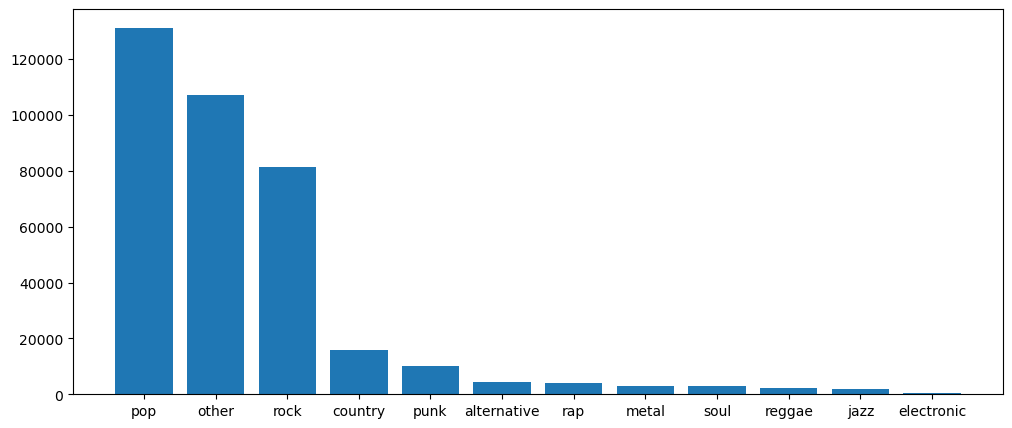

In [15]:
baseline_genre_counter = Counter(chord_data.genres)
baseline_genres, baseline_values = zip(*baseline_genre_counter.most_common())
plt.figure(figsize=(12,5))
plt.bar(x = baseline_genres, 
        height = baseline_values)
plt.show()

In [35]:
# For a given n-gram, make a bar chart of genre distribution
def genre_bars(data, n_gram, column_name):
    # Given an input n-gram (in comma-separated string format),
    # find the songs that contain that n-gram,
    # then make a pie chart of the genres of those songs

    # make a deep copy of the data
    df = copy.deepcopy(data)
    
    # add a one-hot binary encoded column for containing the n-gram
    df[column_name] = df['chords'].apply(lambda song : int(contains_n_gram(song, n_gram)))
    
    # ake a filtered dataframe, containing only songs with the given n-gram
    filtered_df = df[df[column_name] == 1]

    # build some counter objects, and lists of values for bar chart making
    filtered_genre_counter = Counter(filtered_df.genres) # the counter for songs containing the fixed n_gram
    baseline_genre_counter = Counter(chord_data.genres)
    values_filtered = [filtered_genre_counter.get(g,0) for g in major_genres]
    values_baseline = [baseline_genre_counter.get(g,0) for g in major_genres]

    # normalize the data   
    total_filtered = sum(values_filtered)
    total_baseline = sum(values_baseline)
    normalized_values_filtered = [v / total_filtered for v in values_filtered]
    normalized_values_baseline = [v / total_baseline for v in values_baseline]
    
    # make bar charts of the genres of the remaining songs
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                             ncols = 2,
                             figsize = (22,5),
                             sharey = True)
    ax1.bar(x = major_genres,
            height = normalized_values_filtered)
    ax1.set_title('Genre distribution for songs containing ' + n_gram + ' or harmonic equivalent')

    # Plot alongside a baseline genre distribution
    ax2.bar(x = major_genres, 
            height = normalized_values_baseline)
    ax2.set_title('Genre distribution for all songs')
    
    plt.show()

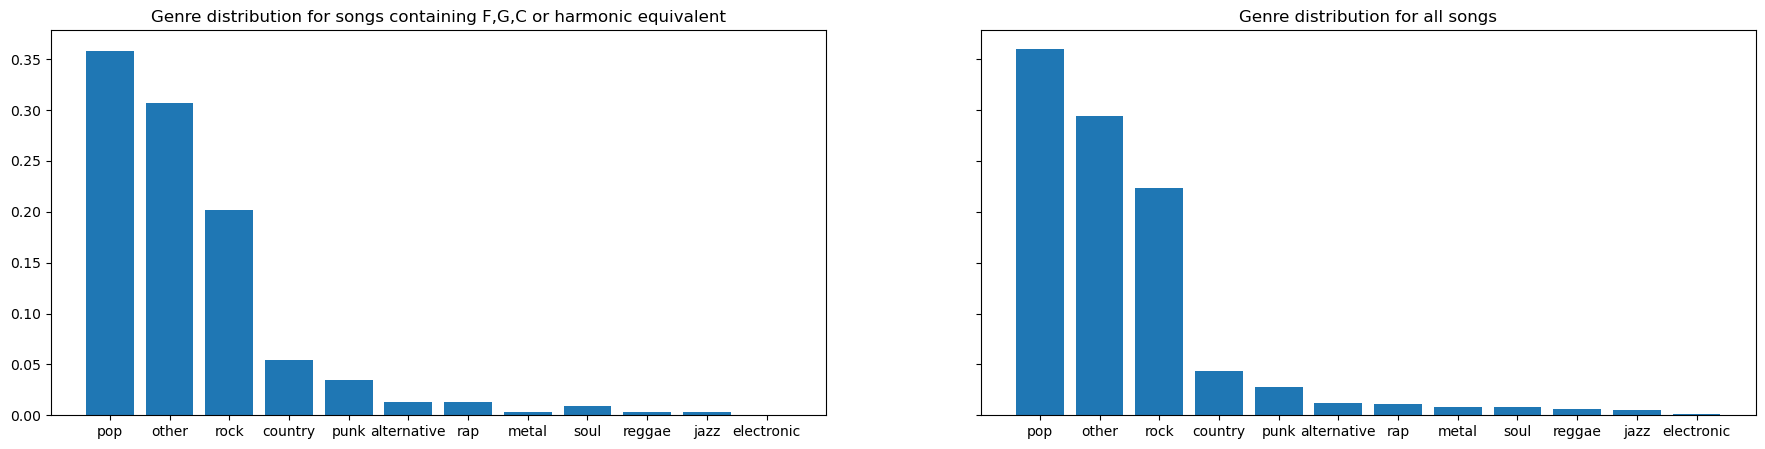

In [39]:
sample_size = 1000
sample_data = chord_data.sample(sample_size)
genre_bars(data = sample_data,
           n_gram = 'F,G,C',
           column_name = '451')